# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [323]:
import lightgbm as lgb
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from scipy.stats import randint, uniform
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR


In [324]:
df = pd.read_csv('autos.csv')

In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [326]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
df.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


KeyboardInterrupt: 

## Определение основных параметров

In [ ]:
def general_info(column):
    print(df[column].value_counts())
    print('Количество пропусков:', df[column].isna().sum())

## DateCrawled

In [ ]:
general_info('DateCrawled')

2016-03-24 14:49:47    7
2016-03-26 22:57:31    6
2016-03-19 21:49:56    6
2016-04-02 14:50:21    5
2016-03-23 13:50:19    5
                      ..
2016-03-20 16:48:06    1
2016-03-22 21:51:04    1
2016-03-11 16:25:36    1
2016-03-31 12:47:30    1
2016-03-19 18:57:12    1
Name: DateCrawled, Length: 271174, dtype: int64
Количество пропусков: 0


## Price

Количество пропусков: 0


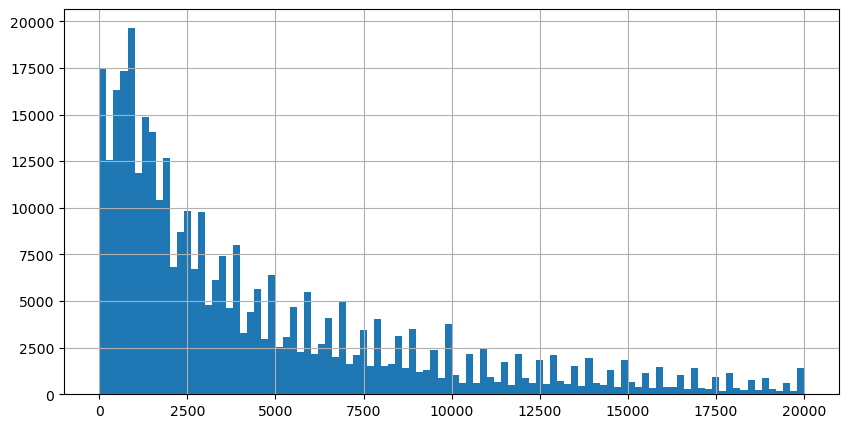

In [ ]:
print('Количество пропусков:', df['Price'].isna().sum())
df['Price'].hist(bins=100, figsize=(10, 5));

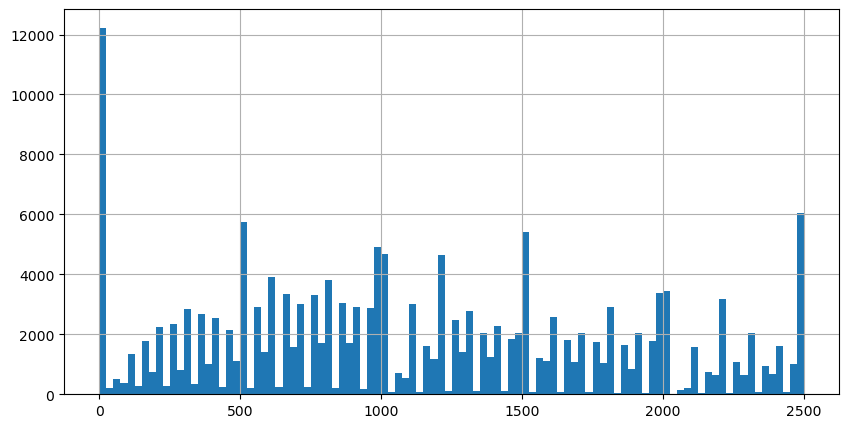

In [ ]:
df['Price'].hist(bins=100, figsize=(10, 5), range=(0, 2500));

In [ ]:
print('Количество нулевых значений:', df[df['Price'] == 0]['Price'].count())

Количество нулевых значений: 10772


## VehicleType

In [ ]:
general_info('VehicleType')

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64
Количество пропусков: 37490


In [ ]:
df[df['VehicleType'].isna()].describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,37490,37490.000000,0,37490.000000,27520,37490.000000,30662,37490.000000,37490.000000,20195,37490,16919,37490,37490.0,37490.000000,37490
unique,36331,NaN,0,NaN,2,NaN,241,NaN,NaN,7,40,2,64,NaN,NaN,32537
top,2016-03-25 16:51:10,NaN,NaN,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-03-20 00:00:00,NaN,NaN,2016-04-06 04:16:06
freq,3,NaN,NaN,NaN,23522,NaN,4035,NaN,NaN,14807,9710,13027,1380,NaN,NaN,6
mean,NaN,2375.427954,NaN,2021.098773,NaN,70.569592,NaN,127180.848226,3.841211,NaN,NaN,NaN,NaN,0.0,47964.240891,NaN
std,NaN,3213.002249,NaN,276.173531,NaN,216.707321,NaN,43882.411412,4.043364,NaN,NaN,NaN,NaN,0.0,25613.384004,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,400.000000,NaN,2005.000000,NaN,0.000000,NaN,125000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,27392.750000,NaN
50%,NaN,1199.000000,NaN,2016.000000,NaN,61.000000,NaN,150000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,46119.000000,NaN
75%,NaN,2999.000000,NaN,2017.000000,NaN,105.000000,NaN,150000.000000,7.000000,NaN,NaN,NaN,NaN,0.0,66499.250000,NaN


## RegistrationYear

In [ ]:
general_info('RegistrationYear')

2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
6500        1
2290        1
1001        1
9450        1
3500        1
Name: RegistrationYear, Length: 151, dtype: int64
Количество пропусков: 0


## Gearbox

In [ ]:
general_info('Gearbox')

manual    268251
auto       66285
Name: Gearbox, dtype: int64
Количество пропусков: 19833


## Power

In [ ]:
general_info('Power')

0       40225
75      24023
60      15897
150     14590
101     13298
        ...  
610         1
6006        1
5815        1
6018        1
1241        1
Name: Power, Length: 712, dtype: int64
Количество пропусков: 0


## Model

In [ ]:
general_info('Model')

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64
Количество пропусков: 19705


## Kilometer

150000    238209
125000     36454
100000     14882
90000      11567
80000      10047
70000       8593
60000       7444
5000        6397
50000       6232
40000       4911
30000       4436
20000       3975
10000       1222
Name: Kilometer, dtype: int64
Количество пропусков: 0


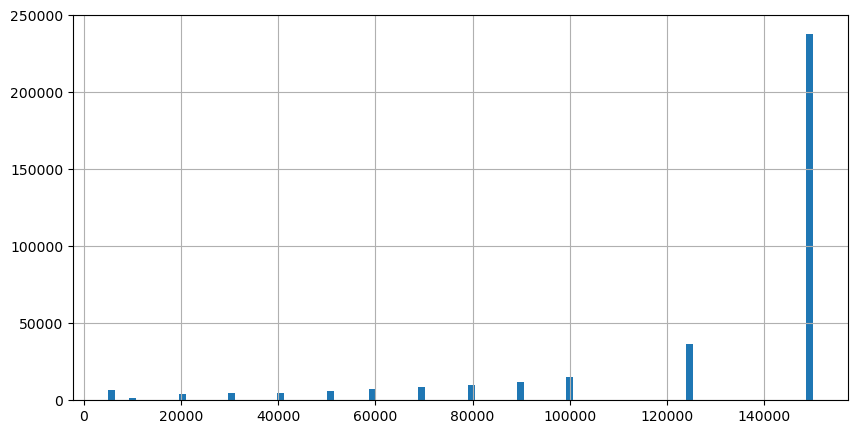

In [ ]:
general_info('Kilometer')
df['Kilometer'].hist(bins=100, figsize=(10, 5));

## RegistrationMonth

In [ ]:
general_info('RegistrationMonth')

0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: RegistrationMonth, dtype: int64
Количество пропусков: 0


## FuelType

In [ ]:
general_info('FuelType')

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64
Количество пропусков: 32895


## Brand

In [ ]:
general_info('Brand')

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64
Количество про

## Repaired

In [ ]:
general_info('Repaired') 

no     247161
yes     36054
Name: Repaired, dtype: int64
Количество пропусков: 71154


## DateCreated

In [ ]:
general_info('DateCreated')

2016-04-03 00:00:00    13719
2016-04-04 00:00:00    13317
2016-03-20 00:00:00    12918
2016-03-12 00:00:00    12840
2016-03-21 00:00:00    12691
                       ...  
2015-08-07 00:00:00        1
2015-12-27 00:00:00        1
2015-11-12 00:00:00        1
2015-12-06 00:00:00        1
2015-06-18 00:00:00        1
Name: DateCreated, Length: 109, dtype: int64
Количество пропусков: 0


## NumberOfPictures

In [ ]:
general_info('NumberOfPictures')

0    354369
Name: NumberOfPictures, dtype: int64
Количество пропусков: 0


## PostalCode

In [ ]:
general_info('PostalCode')

10115    819
65428    613
66333    343
32257    317
44145    317
        ... 
91801      1
31097      1
82444      1
94359      1
31096      1
Name: PostalCode, Length: 8143, dtype: int64
Количество пропусков: 0


## LastSeen

In [ ]:
general_info('LastSeen')

2016-04-06 13:45:54    17
2016-04-07 09:45:10    16
2016-04-06 01:15:23    16
2016-04-06 10:15:26    16
2016-04-07 05:44:30    16
                       ..
2016-03-07 17:46:17     1
2016-03-10 07:49:15     1
2016-04-03 04:18:11     1
2016-03-16 20:19:54     1
2016-03-21 10:42:49     1
Name: LastSeen, Length: 179150, dtype: int64
Количество пропусков: 0


## Дубликатов

In [ ]:
# Проверим дубликаты
print(df.duplicated().sum())

# Удалим дубликаты
df = df.drop_duplicates().reset_index(drop=True)

4


# Подготовка признаков и Pipeline

In [ ]:
X = df.drop(['Price', "DateCrawled", "DateCreated", "LastSeen", "NumberOfPictures"], axis=1)
y = df['Price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Обучение моделей

## LinearRegression

In [ ]:
lr = Ridge()

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lr', lr)
])

lr_param_grid = {
    'lr__alpha': np.logspace(-6, 6, 13),
    'lr__fit_intercept': [True, False],
}

lr_grid = RandomizedSearchCV(lr_pipeline, 
                   lr_param_grid, 
                   cv=5, 
                   scoring='neg_mean_squared_error', 
                   n_jobs=8, 
                   verbose=2)

In [ ]:
%%time
lr_fitted = lr_grid.fit(X_train, y_train)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 8.11 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..........lr__alpha=10000.0, lr__fit_intercept=True; total time=   0.6s
[CV] END ..........lr__alpha=10000.0, lr__fit_intercept=True; total time=   0.6s
[CV] END ..........lr__alpha=10000.0, lr__fit_intercept=True; total time=   0.6s
[CV] END ..........lr__alpha=10000.0, lr__fit_intercept=True; total time=   0.7s
[CV] END ..........lr__alpha=10000.0, lr__fit_intercept=True; total time=   0.7s
[CV] END ...........lr__alpha=1000.0, lr__fit_intercept=True; total time=   0.8s
[CV] END ...........lr__alpha=1000.0, lr__fit_intercept=True; total time=   0.8s
[CV] END ...........lr__alpha=1000.0, lr__fit_intercept=True; total time=   0.9s
[CV] END ...........lr__alpha=1000.0, lr__fit_intercept=True; total time=   0.9s
[CV] END .........lr__alpha=100000.0, lr__fit_intercept=True; total time=   0.7s
[CV] END ...........lr__alpha=1000.0, lr__fit_intercept=True;

In [ ]:
%%time
lr_predict = lr_fitted.predict(X_test)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 13.1 µs


In [ ]:
lr_rmse = mean_squared_error(y_test, lr_predict) ** 0.5
print('LR RMSE:', lr_rmse)
print("Лучшие параметры:", lr_grid.best_params_)

LR RMSE: 3229.501601797225
Лучшие параметры: {'lr__fit_intercept': True, 'lr__alpha': 1.0}


## Random Forest Regressor

In [ ]:
rfr = RandomForestRegressor(random_state=42, n_jobs=-1)

rfr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfr', rfr)
])

rfr_param_grid = {
    'rfr__n_estimators': [100, 200],
    'rfr__max_depth': [10, 20],
    'rfr__min_samples_leaf': [1, 2]
}

rfr_grid = RandomizedSearchCV(rfr_pipeline, 
                   rfr_param_grid, 
                   random_state=42,
                   cv=5, 
                   scoring='neg_mean_squared_error', 
                   n_jobs=8, 
                   verbose=2)

In [ ]:
%%time
rfr_fitted = rfr_grid.fit(X_train, y_train)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 µs
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END rfr__max_depth=10, rfr__min_samples_leaf=1, rfr__n_estimators=100; total time= 3.3min
[CV] END rfr__max_depth=10, rfr__min_samples_leaf=1, rfr__n_estimators=100; total time= 3.3min
[CV] END rfr__max_depth=10, rfr__min_samples_leaf=1, rfr__n_estimators=100; total time= 3.3min
[CV] END rfr__max_depth=10, rfr__min_samples_leaf=1, rfr__n_estimators=100; total time= 3.4min
[CV] END rfr__max_depth=10, rfr__min_samples_leaf=1, rfr__n_estimators=100; total time= 3.4min
[CV] END rfr__max_depth=10, rfr__min_samples_leaf=1, rfr__n_estimators=200; total time= 6.6min
[CV] END rfr__max_depth=10, rfr__min_samples_leaf=1, rfr__n_estimators=200; total time= 6.7min
[CV] END rfr__max_depth=10, rfr__min_samples_leaf=1, rfr__n_estimators=200; total time= 6.7min
[CV] END rfr__max_depth=10, rfr__min_samples_leaf=1, rfr__n_estimators=200; total time= 6.7min
[CV] END rfr__max_depth=10, rfr__min_samples_leaf=1, rfr__n_estimators=200; total time= 6.7min
[CV] END rfr__max_depth=10, rfr__min_samples_leaf=

/Users/vs/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END rfr__max_depth=20, rfr__min_samples_leaf=1, rfr__n_estimators=100; total time=21.9min
[CV] END rfr__max_depth=20, rfr__min_samples_leaf=1, rfr__n_estimators=100; total time=21.9min
[CV] END rfr__max_depth=20, rfr__min_samples_leaf=1, rfr__n_estimators=100; total time=21.9min
[CV] END rfr__max_depth=20, rfr__min_samples_leaf=1, rfr__n_estimators=100; total time=22.0min
[CV] END rfr__max_depth=20, rfr__min_samples_leaf=2, rfr__n_estimators=100; total time=17.3min
[CV] END rfr__max_depth=20, rfr__min_samples_leaf=2, rfr__n_estimators=100; total time=17.3min
[CV] END rfr__max_depth=20, rfr__min_samples_leaf=2, rfr__n_estimators=100; total time=17.4min
[CV] END rfr__max_depth=20, rfr__min_samples_leaf=2, rfr__n_estimators=100; total time=17.4min
[CV] END rfr__max_depth=20, rfr__min_samples_leaf=2, rfr__n_estimators=100; total time=17.4min
[CV] END rfr__max_depth=20, rfr__min_samples_leaf=1, rfr__n_estimators=200; total time=43.4min
[CV] END rfr__max_depth=20, rfr__min_samples_leaf=

In [ ]:
%%time
rfr_predict = rfr_fitted.predict(X_test)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.96 µs


In [ ]:
rfr_rmse = mean_squared_error(y_test, predict) ** 0.5
print('RFR RMSE:', rfr_rmse)
print("Лучшие параметры:", rfr_grid.best_params_)

RFR RMSE: 6201.380150954196
Лучшие параметры: {'rfr__n_estimators': 200, 'rfr__min_samples_leaf': 2, 'rfr__max_depth': 20}


## Support Vector Regression 

In [339]:
svr = SVR()

svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svr', svr)
])

svr_param_grid = {
    'svr__C': np.logspace(-3, 3, 7),
    'svr__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svr__gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'svr__degree': [2, 3, 4, 5],
    'svr__coef0': np.linspace(-1, 1, 5),
    'svr__shrinking': [True, False],
    'svr__epsilon': np.linspace(0.01, 1, 10)
}

svr_grid = RandomizedSearchCV(svr_pipeline, 
                   svr_param_grid, 
                   random_state=42,
                   cv=2, 
                   scoring='neg_mean_squared_error', 
                   n_jobs=8, 
                   verbose=2)

In [343]:
%%time
model = svr_pipeline()
svr_fitted = model.fit(X_train, y_train)

TypeError: 'Pipeline' object is not callable

In [ ]:
%%time
svr_predict = svr_fitted.predict(X_test)

In [ ]:
svr_rmse = mean_squared_error(y_test, svr_predict) ** 0.5
print('SVR RMSE:', svr_rmse)
print("Лучшие параметры:", svr_grid.best_params_)

## K Neighbors Regressor

In [ ]:
knr = KNeighborsRegressor()

knr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knr', knr)
])

knr_param_grid = {
    'knr__n_neighbors': list(range(1, 31)),
    'knr__weights': ['uniform', 'distance'],
    'knr__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knr__p': [1, 2],
    'knr__leaf_size': list(range(10, 51))
}

knr_grid = RandomizedSearchCV(knr_pipeline, 
                   knr_param_grid, 
                   random_state=42,
                   cv=2, 
                   scoring='neg_mean_squared_error', 
                   n_jobs=8, 
                   verbose=2)

In [ ]:
%%time
knr_fitted = knr_grid.fit(X_train, y_train)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.15 µs
Fitting 2 folds for each of 10 candidates, totalling 20 fits


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_base.py:564: UserWarning: cannot use tree with sparse in

KeyboardInterrupt: 

In [ ]:
%%time
knr_predict = knr_fitted.predict(X_test)

In [ ]:
knr_rmse = mean_squared_error(y_test, knr_predict) ** 0.5
print('KNR RMSE:', knr_rmse)
print("Лучшие параметры:", knr_grid.best_params_)

## LightGBM

In [328]:
lgbm = lgb.LGBMRegressor()

lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lgbm', lgbm)
])

lgbm_param_grid = {
    'lgbm__num_leaves': randint(6, 50),
    'lgbm__min_child_samples': randint(100, 500),
    'lgbm__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'lgbm__subsample': uniform(loc=0.2, scale=0.8),
    'lgbm__colsample_bytree': uniform(loc=0.4, scale=0.6),
    'lgbm__reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'lgbm__reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
    'lgbm__learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'lgbm__n_estimators': [100, 200, 500, 1000, 2000]
}

lgbm_grid = RandomizedSearchCV(lgbm_pipeline, 
                   lgbm_param_grid, 
                   random_state=42,
                   cv=2, 
                   scoring='neg_mean_squared_error', 
                   n_jobs=8, 
                   verbose=2)

In [329]:
%%time
lgbm_fitted = lgbm_grid.fit(X_train, y_train)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 13.8 µs
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END lgbm__colsample_bytree=0.9631316254094501, lgbm__learning_rate=0.05, lgbm__min_child_samples=291, lgbm__min_child_weight=1, lgbm__n_estimators=100, lgbm__num_leaves=17, lgbm__reg_alpha=7, lgbm__reg_lambda=10, lgbm__subsample=0.5455560149136927; total time=   2.4s
[CV] END lgbm__colsample_bytree=0.9631316254094501, lgbm__learning_rate=0.05, lgbm__min_child_samples=291, lgbm__min_child_weight=1, lgbm__n_estimators=100, lgbm__num_leaves=17, lgbm__reg_alpha=7, lgbm__reg_lambda=10, lgbm__subsample=0.5455560149136927; total time=   2.7s
[CV] END lgbm__colsample_bytree=0.5747374841188252, lgbm__learning_rate=0.1, lgbm__min_child_samples=269, lgbm__min_child_weight=0.01, lgbm__n_estimators=1000, lgbm__num_leaves=8, lgbm__reg_alpha=5, lgbm__reg_lambda=1, lgbm__subsample=0.7442460308702239; total time=  10.1s
[CV] END lgbm__colsample_bytree=0.5747374841188252,

In [330]:
%%time
lgbm_predict = lgbm_fitted.predict(X_test)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 9.06 µs


In [331]:
lgbm_rmse = mean_squared_error(y_test, lgbm_predict) ** 0.5
print('LGBM RMSE:', lgbm_rmse)
print("Лучшие параметры:", lgbm_grid.best_params_)

LGBM RMSE: 1759.2561624636403
Лучшие параметры: {'lgbm__colsample_bytree': 0.45860326840383037, 'lgbm__learning_rate': 0.5, 'lgbm__min_child_samples': 191, 'lgbm__min_child_weight': 100.0, 'lgbm__n_estimators': 1000, 'lgbm__num_leaves': 13, 'lgbm__reg_alpha': 1, 'lgbm__reg_lambda': 20, 'lgbm__subsample': 0.5128484860585927}


## CatBoost

In [334]:
cbr = CatBoostRegressor()

cbr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cbr', cbr)
])

cbr_param_grid = {
    'cbr__iterations': randint(100, 1000),
    'cbr__depth': randint(1, 8),
    'cbr__learning_rate': uniform(0.01, 0.3),
    'cbr__l2_leaf_reg': randint(2, 30),
    'cbr__border_count': randint(1, 255),
    'cbr__thread_count': [4]
}

cbr_grid = RandomizedSearchCV(cbr_pipeline, 
                   cbr_param_grid, 
                   random_state=42,
                   cv=2, 
                   scoring='neg_mean_squared_error', 
                   n_jobs=8, 
                   verbose=2)

In [335]:
%%time
cbr_fitted = cbr_grid.fit(X_train, y_train)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 15.7 µs
Fitting 2 folds for each of 10 candidates, totalling 20 fits
0:	learn: 3963.7881974	total: 157ms	remaining: 2m 31s
0:	learn: 3983.7486230	total: 175ms	remaining: 2m 47s
1:	learn: 3569.7645170	total: 186ms	remaining: 1m 29s
1:	learn: 3529.8773843	total: 191ms	remaining: 1m 31s
2:	learn: 3241.7454018	total: 203ms	remaining: 1m 4s
2:	learn: 3284.6929039	total: 219ms	remaining: 1m 9s
3:	learn: 3014.2975197	total: 217ms	remaining: 51.8s
4:	learn: 2861.4286405	total: 228ms	remaining: 43.5s
3:	learn: 3047.8592345	total: 233ms	remaining: 55.7s
4:	learn: 2878.4492354	total: 242ms	remaining: 46.2s
5:	learn: 2738.2408919	total: 240ms	remaining: 38.1s
5:	learn: 2770.0493367	total: 252ms	remaining: 40.1s
6:	learn: 2651.5911643	total: 254ms	remaining: 34.6s
6:	learn: 2663.2712939	total: 261ms	remaining: 35.6s
7:	learn: 2592.2121846	total: 272ms	remaining: 32.4s
0:	learn: 4102.2603177	total: 77.8ms	remaining: 14.5s
7:	learn: 2576.349

In [336]:
%%time
cbr_predict = cbr_fitted.predict(X_test)

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 16.9 µs


In [337]:
cbr_rmse = mean_squared_error(y_test, cbr_predict) ** 0.5
print('CBR RMSE:', cbr_rmse)
print("Лучшие параметры:", cbr_grid.best_params_)

CBR RMSE: 1751.2466656650615
Лучшие параметры: {'cbr__border_count': 190, 'cbr__depth': 7, 'cbr__iterations': 662, 'cbr__l2_leaf_reg': 13, 'cbr__learning_rate': 0.1642703315240835, 'cbr__thread_count': 4}


## Анализ моделей

# Идеи

1. Удалить нулевые цены
2. Заполнить VehicleType на основаниии model
3. Заполнить Gearbox на основании Model
4. Заполнить Model на основании VehicleType, оставшиеся заполним самым популярным Brand
5. Заполнить FuelType на основании Model, оставшиеся заполнить самым популярным Brand

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей